In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

from tensorflow.keras.preprocessing.image import load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
import tensorflow as tf


!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
fid = drive.ListFile({'q':"title='facemo.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('facemo.zip')
f.keys()
!unzip facemo.zip

In [53]:
gpus = tf.config.list_logical_devices('GPU') 
stg=tf.distribute.MirroredStrategy(gpus)

In [54]:
folder_path = "/content/facemo/images/" 
# folder_path = "../input/face-expression-recognition-dataset/images/"
# validation_folder_path = "../input/face-expression-recognition-dataset/images/"

In [55]:
import cv2
import os
from tqdm import tqdm

folder_dir = '/content/facemo/images/train'
SIZE = 75
DOWNSAMPLE_RATIO = 4
JPEG_QUALITY = 100

# get the total number of files to process
total_files = sum(len(files) for _, _, files in os.walk(folder_dir))

# use tqdm to display a progress bar
with tqdm(total=total_files, desc="Processing Images") as pbar:
    for folder in os.listdir(folder_dir):
        for file in os.listdir(os.path.join(folder_dir, folder)):
            if file.endswith("jpg"):
                image_path = os.path.join(folder_dir, folder, file)
                img = cv2.imread(image_path)
                img_resized = cv2.resize(img, (SIZE,SIZE))
                cv2.imwrite(image_path, img_resized)
                pbar.update(1) # increment the progress bar
            else:
                continue


Processing Images: 100%|██████████| 2827/2827 [00:01<00:00, 2732.93it/s]


In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers



In [57]:
batch_size = 32
picture_size = (SIZE,SIZE)
datagen_train = ImageDataGenerator(rescale=1./255)

datagen_val = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

In [58]:
train_generator = train_datagen.flow_from_directory(folder_path + 'train',
                                                    target_size=(picture_size),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

validation_set = test_datagen.flow_from_directory(folder_path + 'validation',
                                                        target_size=(picture_size),
                                                        batch_size=batch_size,
                                                        class_mode='categorical')

Found 2827 images belonging to 5 classes.
Found 797 images belonging to 5 classes.


In [69]:
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
import keras
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation, RandomTranslation, RandomFlip, RandomZoom
from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from tensorflow.keras.optimizers import RMSprop,SGD,Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
from tensorflow.keras.applications import DenseNet121
import random
import matplotlib.pyplot as plt
from tensorflow.keras.applications import InceptionV3


no_of_classes = 5

with stg.scope():
    img_augmentation = Sequential(
    [
        RandomRotation(factor=0.15),
        RandomTranslation(height_factor=0.1, width_factor=0.1),
        RandomFlip(),
        RandomZoom(height_factor=0.2)
    ],
    name="img_augmentation"
    )

    # Define base model
    base_model = InceptionV3(weights="imagenet", input_shape=(SIZE, SIZE, 3), include_top=False)
    for layer in base_model.layers:
      layer.trainable = False
    # Add image augmentation as the first layer of base model
    inputs = Input(shape=(SIZE, SIZE, 3))
    x = img_augmentation(inputs)
    outputs = base_model(x)

    # Add classification layers on top of the base model
    x = GlobalAveragePooling2D()(outputs)
    x = Dense(512, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(no_of_classes, activation='softmax')(x)

    # Define the model
    model = Model(inputs=inputs, outputs=predictions)

    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(lr=0.001),
        metrics=['accuracy'])

model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 75, 75, 3)]       0         
                                                                 
 img_augmentation (Sequentia  (None, 75, 75, 3)        0         
 l)                                                              
                                                                 
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 global_average_pooling2d_9   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_27 (Dense)            (None, 512)               1049088   
                                                                 
 dense_28 (Dense)            (None, 128)               6566

In [70]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss',
                                 factor=0.1,
                                 patience=2,
                                 verbose=1)

callbacks = [lr_scheduler]


In [71]:
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.n // batch_size,
                    epochs=32,
                    validation_data=validation_set,
                    validation_steps=validation_set.n // batch_size,
                    callbacks=callbacks)

Epoch 1/32
88/88 [==============================] - 15s 65ms/step - loss: 1.4302 - accuracy: 0.4254 - val_loss: 1.1596 - val_accuracy: 0.4818 - lr: 0.0010
Epoch 2/32
88/88 [==============================] - 3s 36ms/step - loss: 1.1145 - accuracy: 0.5714 - val_loss: 1.1676 - val_accuracy: 0.5495 - lr: 0.0010
Epoch 3/32
88/88 [==============================] - 5s 56ms/step - loss: 0.9941 - accuracy: 0.6125 - val_loss: 0.9941 - val_accuracy: 0.5833 - lr: 0.0010
Epoch 4/32
88/88 [==============================] - 3s 39ms/step - loss: 0.8836 - accuracy: 0.6655 - val_loss: 0.9194 - val_accuracy: 0.6484 - lr: 0.0010
Epoch 5/32
88/88 [==============================] - 3s 39ms/step - loss: 0.7779 - accuracy: 0.7106 - val_loss: 0.8934 - val_accuracy: 0.6953 - lr: 0.0010
Epoch 6/32
88/88 [==============================] - 5s 54ms/step - loss: 0.7255 - accuracy: 0.7367 - val_loss: 0.8839 - val_accuracy: 0.6133 - lr: 0.0010
Epoch 7/32
88/88 [==============================] - 3s 37ms/step - loss: 0.

In [72]:
test_loss, test_acc = model.evaluate(validation_set)
print('Test accuracy:', test_acc)

25/25 [==============================] - 2s 60ms/step - loss: 0.6072 - accuracy: 0.7867
Test accuracy: 0.7867001295089722


0 = Angry
1 = Happy
2 = Neutral
3 = Sad
4 = Surprise
1/1 [==============================] - 2s 2s/step


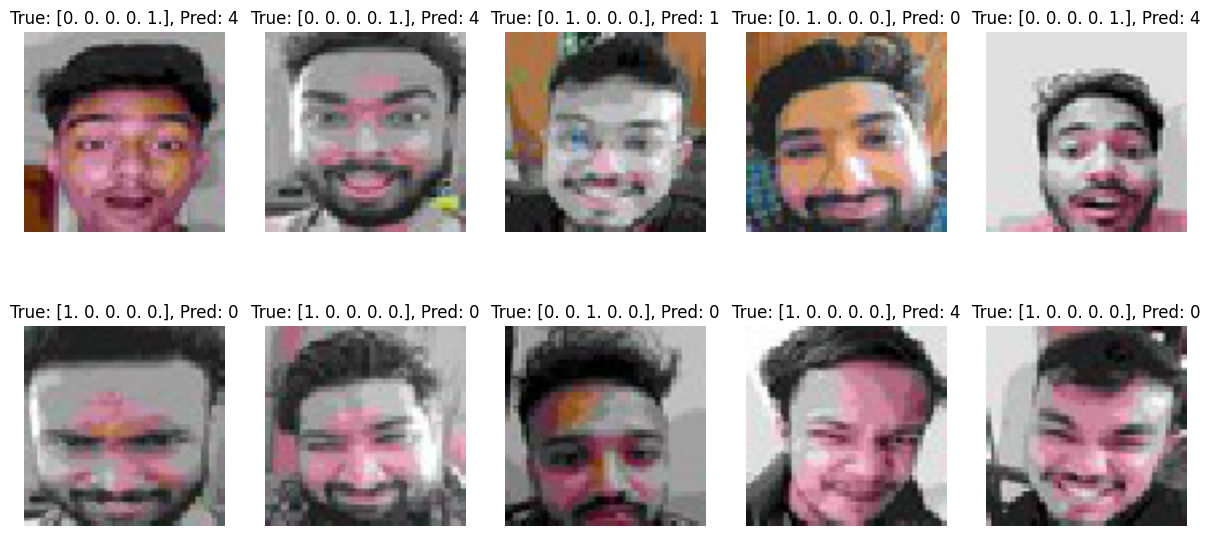

In [73]:
import numpy as np
import matplotlib.pyplot as plt
e = ['Angry','Happy','Neutral','Sad','Surprise']
for i in range(len(e)):
    print(i,"=",e[i])
# Get a batch of 10 random images from the test set
test_batch = validation_set.next()
images = test_batch[0][:10]
true_labels = test_batch[1][:10]

# Make predictions using the trained model
pred_probs = model.predict(images)
pred_labels = np.argmax(pred_probs, axis=1)

# Plot the images with their true and predicted labels
fig, axs = plt.subplots(2, 5, figsize=(15, 7))
axs = axs.flatten()

for i in range(len(images)):
    # Rescale the pixel values from [0, 1] to [0, 255] and convert to integers
    img = (images[i] * 255).astype(np.uint8)
    # Invert the pixel values
    axs[i].imshow(img)
    axs[i].set_title(f'True: {true_labels[i]}, Pred: {pred_labels[i]}')
    axs[i].axis('off')

plt.show()

